
Processing ballet.jpg...
Original size of ballet.jpg: (460, 260)
Resized size of ballet.jpg: (460, 260)


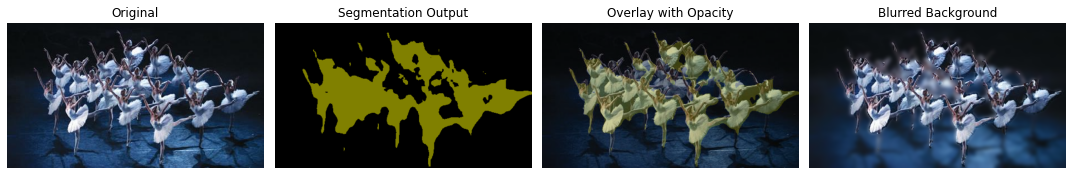


Processing lake.jpg...
Original size of lake.jpg: (1527, 850)
Resized size of lake.jpg: (460, 260)


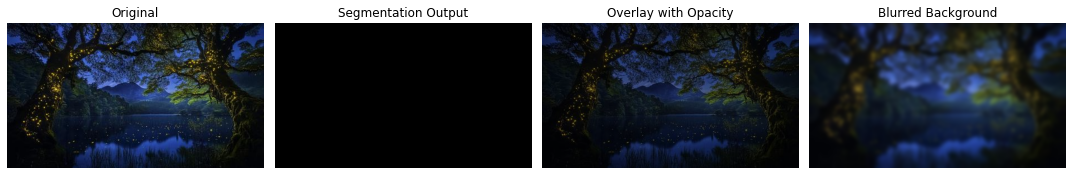


Processing ltt.jpg...
Original size of ltt.jpg: (570, 299)
Resized size of ltt.jpg: (460, 260)


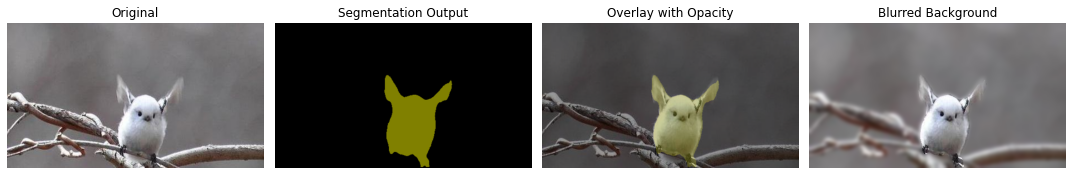

In [16]:
import os
import cv2
import numpy as np
from PIL import Image
from pixellib.semantic import semantic_segmentation
import matplotlib.pyplot as plt


# **모듈 1: 가장 작은 이미지 크기 계산**
def get_minimum_size(image_files):
    try:
        sizes = [Image.open(file).size for file in image_files]
        min_width = min(size[0] for size in sizes)
        min_height = min(size[1] for size in sizes)
        return min_width, min_height
    except Exception as e:
        print(f"Error calculating minimum size: {e}")
        return None  # 에러 발생 시 None 반환

# **모듈 2: 이미지 리사이징**
def resize_image(image_path, target_size):
    img = Image.open(image_path)
    resized_img = img.resize(target_size, Image.LANCZOS)
    return resized_img


# **모듈 3: 세그멘테이션 모델 초기화**
def initialize_segmentation_model(model_dir='./'):
    model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')
    if not os.path.exists(model_file):
        model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
        print("Downloading model...")
        import urllib.request
        urllib.request.urlretrieve(model_url, model_file)
        print("Model downloaded!")
    
    model = semantic_segmentation()
    model.load_pascalvoc_model(model_file)
    return model


# **모듈 4: 세그멘테이션 수행**
def perform_segmentation(model, image_path):
    segvalues, output = model.segmentAsPascalvoc(image_path)
    return segvalues, output


# **모듈 5: 오파시티 적용된 이미지 생성**
def apply_opacity(img, segmentation_output, opacity=0.4):
    output_resized = cv2.resize(segmentation_output, (img.shape[1], img.shape[0]))
    overlay = cv2.addWeighted(img, 1 - opacity, output_resized, opacity, 0)
    return overlay


# **모듈 6: 배경 블러 처리**
def blur_background(img, segmentation_output):
    background_class_id = 0
    seg_map = np.all(segmentation_output == np.array([background_class_id] * 3), axis=-1)
    
    img_blur = cv2.GaussianBlur(img, (21, 21), 0)
    
    mask = seg_map.astype(np.uint8) * 255
    mask_inv = cv2.bitwise_not(mask)
    
    img_target = cv2.bitwise_and(img_blur, img_blur, mask=mask)
    img_foreground = cv2.bitwise_and(img, img, mask=mask_inv)
    
    result_img = cv2.add(img_target, img_foreground)
    return result_img


# **모듈 7: 이미지 시각화**
def visualize_images(images, titles):
    plt.figure(figsize=(15, 5))
    for i, (img, title) in enumerate(zip(images, titles), 1):
        plt.subplot(1, len(images), i)
        if isinstance(img, np.ndarray):  # OpenCV 이미지 처리
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:  # PIL 이미지 처리
            plt.imshow(np.array(img))
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


# **메인 함수**
def process_image(image_path, target_size=None, model=None):
    # 원본 이미지 로드 및 크기 확인
    original_img = Image.open(image_path)
    
    print(f"Original size of {image_path}: {original_img.size}")
    
    # 리사이징 (제일 작은 크기로 설정된 target_size 사용)
    resized_img = resize_image(image_path, target_size)
    
    print(f"Resized size of {image_path}: {resized_img.size}")
    
    # 리사이징된 이미지 저장
    resized_file_path = f"resized_{os.path.basename(image_path)}"
    resized_img.save(resized_file_path)
    
    # 세그멘테이션 수행
    if model is None:
        raise ValueError("Segmentation model is not initialized.")
    
    segvalues, segmentation_output = perform_segmentation(model, resized_file_path)

    # OpenCV로 이미지를 읽어오기 (세그멘테이션 및 블러 작업용)
    img_cv2 = cv2.imread(resized_file_path)

    # 오파시티 적용된 이미지 생성
    overlay_img = apply_opacity(img_cv2, segmentation_output)

    # 배경 블러 처리된 이미지 생성
    blurred_background_img = blur_background(img_cv2, segmentation_output)

    # 결과 시각화
    visualize_images(
        [img_cv2, segmentation_output, overlay_img, blurred_background_img],
        ["Original", "Segmentation Output", "Overlay with Opacity", "Blurred Background"]
    )


# **전체 실행**
if __name__ == "__main__":
    # 모델 초기화
    segmentation_model = initialize_segmentation_model()

    # 처리할 이미지 파일 리스트
    image_files = ['ballet.jpg', 'lake.jpg', 'ltt.jpg']

    # 제일 작은 크기 계산
    target_size = get_minimum_size(image_files)

    if target_size is None:
        print("Failed to calculate the minimum size. Please check the image files.")
    else:
        for image_file in image_files:
            print(f"\nProcessing {image_file}...")
            process_image(image_file, target_size=target_size, model=segmentation_model)


In [ ]:
# 마스크 후처리 추가
'''
세그멘테이션 출력 이미지를 그레이스케일로 변환.
**이진화(Thresholding)**를 통해 바이너리 마스크 생성.
모폴로지 연산(침식 및 팽창)을 사용하여 노이즈 제거 및 경계 보정.
컨투어 기반 홀 채우기로 객체 내부의 구멍을 채워 일관된 마스크 생성.
'''

In [20]:
# **모듈 : 마스크 후처리**
def refine_segmentation_mask(segmentation_output):
    # 세그멘테이션 출력을 그레이스케일로 변환
    gray_mask = cv2.cvtColor(segmentation_output, cv2.COLOR_BGR2GRAY)

    # 이진화(Thresholding)를 통해 바이너리 마스크 생성
    _, binary_mask = cv2.threshold(gray_mask, 1, 255, cv2.THRESH_BINARY)

    # 모폴로지 연산을 적용하여 마스크 정리
    kernel = np.ones((5, 5), np.uint8)

    # 침식(Erosion)으로 작은 노이즈 제거 후 팽창(Dilation)으로 객체 크기 복원
    cleaned_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

    # 마스크 내부의 구멍을 채우기
    contours, _ = cv2.findContours(cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    refined_mask = np.zeros_like(cleaned_mask)
    
    for contour in contours:
        cv2.drawContours(refined_mask, [contour], -1, (255), thickness=cv2.FILLED)

    # 데이터 타입을 uint8로 변환 (OpenCV 호환성 유지)
    refined_mask = refined_mask.astype(np.uint8)

    return refined_mask


In [21]:
# **수정된 메인 함수**
def process_image(image_path, target_size=None, model=None):
    # 원본 이미지 로드 및 크기 확인
    original_img = Image.open(image_path)
    
    print(f"Original size of {image_path}: {original_img.size}")
    
    # 리사이징 (제일 작은 크기로 설정된 target_size 사용)
    resized_img = resize_image(image_path, target_size)
    
    print(f"Resized size of {image_path}: {resized_img.size}")
    
    # 리사이징된 이미지 저장
    resized_file_path = f"resized_{os.path.basename(image_path)}"
    resized_img.save(resized_file_path)
    
    # 세그멘테이션 수행
    if model is None:
        raise ValueError("Segmentation model is not initialized.")
    
    segvalues, segmentation_output = perform_segmentation(model, resized_file_path)

    # OpenCV로 이미지를 읽어오기 (세그멘테이션 및 블러 작업용)
    img_cv2 = cv2.imread(resized_file_path)

    # 마스크 후처리 적용
    refined_mask = refine_segmentation_mask(segmentation_output)

    # 오파시티 적용된 이미지 생성
    overlay_img = apply_opacity(img_cv2, refined_mask)

    # 배경 블러 처리된 이미지 생성
    blurred_background_img = blur_background(img_cv2, refined_mask)

    # 결과 시각화
    visualize_images(
        [img_cv2, segmentation_output, refined_mask, overlay_img, blurred_background_img],
        ["Original", "Raw Segmentation Output", "Refined Mask", "Overlay with Opacity", "Blurred Background"]
    )


In [ ]:
'''
error: OpenCV(4.5.3) /tmp/pip-req-build-agffqapq/opencv/modules/core/src/arithm.cpp:647: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'

이 에러는 apply_opacity 함수에서 OpenCV의 cv2.addWeighted를 호출할 때, 입력 이미지(img)와 세그멘테이션 마스크(segmentation_output 또는
refined_mask)의 크기나 채널 수가 일치하지 않아서 발생합니다.
'''

In [23]:
# **수정된 모듈 5: 오파시티 적용된 이미지 생성**
def apply_opacity(img, segmentation_output, opacity=0.4):
    # 세그멘테이션 마스크 크기를 원본 이미지 크기에 맞게 조정
    output_resized = cv2.resize(segmentation_output, (img.shape[1], img.shape[0]))

    # 마스크를 3채널로 변환
    if len(output_resized.shape) == 2:  # 만약 마스크가 1채널(그레이스케일)이라면
        output_resized = cv2.cvtColor(output_resized, cv2.COLOR_GRAY2BGR)

    # 오파시티 적용
    overlay = cv2.addWeighted(img, 1 - opacity, output_resized, opacity, 0)
    return overlay


In [ ]:
'''
error: OpenCV(4.5.3) :-1: error: (-5:Bad argument) in function 'bitwise_not'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'

이 에러는 blur_background 함수에서 cv2.bitwise_not 함수에 전달된 mask가 OpenCV에서 처리할 수 없는 형식이기 때문에 발생합니다. 
이 문제는 seg_map 또는 mask가 올바른 NumPy 배열 형식이 아니거나, 데이터 타입이 OpenCV에서 처리할 수 없는 형태로 변환되었기 때문입니다.
'''

In [26]:
# **수정된 모듈 6: 배경 블러 처리**
def blur_background(img, segmentation_output):
    # Background 클래스 ID (PASCAL VOC 데이터셋에서 'background'는 ID 0)
    background_class_id = 0

    # 세그멘테이션 마스크가 그레이스케일(1채널)인지 확인
    if len(segmentation_output.shape) == 2:  # 1채널 (그레이스케일)
        seg_map = segmentation_output == background_class_id
    else:  # 다채널 (RGB)
        seg_map = np.all(segmentation_output == np.array([background_class_id] * 3), axis=-1)

    # Gaussian Blur 적용
    img_blur = cv2.GaussianBlur(img, (21, 21), 0)  # 블러링 커널 크기 (21x21)

    # 마스크 생성
    mask = (seg_map.astype(np.uint8)) * 255

    # 데이터 타입 확인 및 변환
    if not isinstance(mask, np.ndarray):
        mask = np.array(mask, dtype=np.uint8)

    mask_inv = cv2.bitwise_not(mask)

    # 배경 블러와 전경 합성
    img_target = cv2.bitwise_and(img_blur, img_blur, mask=mask)  # 블러 처리된 영역
    img_foreground = cv2.bitwise_and(img, img, mask=mask_inv)   # 원본 전경 영역

    img_result = cv2.add(img_target, img_foreground)  # 두 이미지를 합성

    return img_result



Processing ballet.jpg...
Original size of ballet.jpg: (460, 260)
Resized size of ballet.jpg: (460, 260)


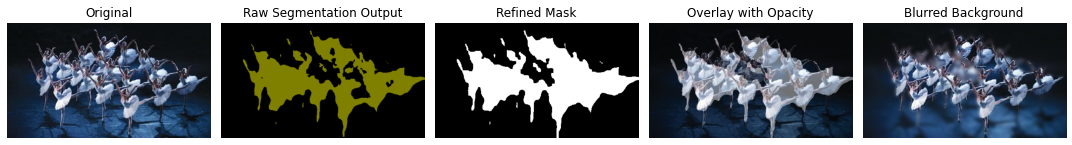


Processing lake.jpg...
Original size of lake.jpg: (1527, 850)
Resized size of lake.jpg: (460, 260)


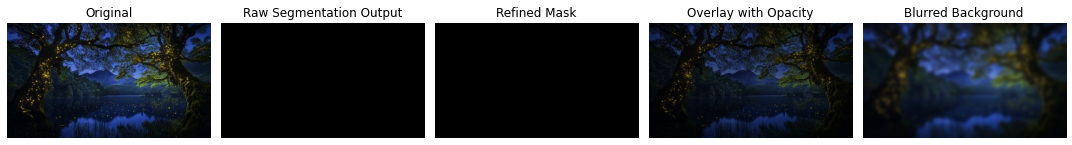


Processing ltt.jpg...
Original size of ltt.jpg: (570, 299)
Resized size of ltt.jpg: (460, 260)


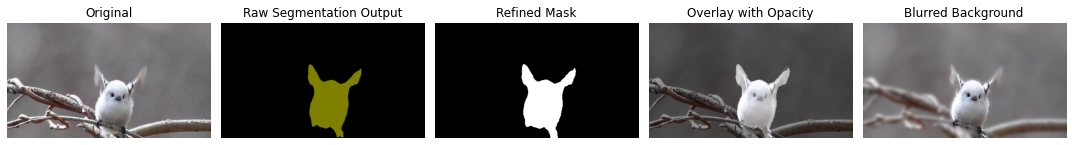

In [27]:
# **수정된 전체 실행**
if __name__ == "__main__":
    # 모델 초기화
    segmentation_model = initialize_segmentation_model()

    # 처리할 이미지 파일 리스트
    image_files = ['ballet.jpg', 'lake.jpg', 'ltt.jpg']

    # 제일 작은 크기 계산
    target_size = get_minimum_size(image_files)

    if target_size is None:
        print("Failed to calculate the minimum size. Please check the image files.")
    else:
        for image_file in image_files:
            print(f"\nProcessing {image_file}...")
            process_image(image_file, target_size=target_size, model=segmentation_model)


In [56]:
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
import torch

# **모듈 3: 세그멘테이션 모델 초기화**
def initialize_segmentation_model(model_dir='./'):
    # SegFormer 모델 및 Feature Extractor 로드
    model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b1-finetuned-cityscapes-1024-1024")
    feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b1-finetuned-cityscapes-1024-1024")
    return model, feature_extractor

from PIL import Image
import numpy as np

# **모듈 4: 세그멘테이션 수행**
def perform_segmentation(model, feature_extractor, image_path):
    # 이미지 로드 및 전처리
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")

    # 모델 추론 수행
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits  # [batch_size, num_classes, height, width]
        segmentation = logits.argmax(dim=1).squeeze().cpu().numpy()

    return segmentation

def process_image(image_path, target_size=None, model=None):
    # 원본 이미지 로드 및 크기 확인
    original_img = Image.open(image_path)
    print(f"Original size of {image_path}: {original_img.size}")
    
    # 리사이징 (제일 작은 크기로 설정된 target_size 사용)
    resized_img = resize_image(image_path, target_size)
    print(f"Resized size of {image_path}: {resized_img.size}")
    
    # 리사이징된 이미지 저장
    resized_file_path = f"resized_{os.path.basename(image_path)}"
    resized_img.save(resized_file_path)
    
    # 세그멘테이션 수행
    if model is None:
        raise ValueError("Segmentation model is not initialized.")
    
    segmentation_output = perform_segmentation(model[0], model[1], resized_file_path)

    # OpenCV로 이미지를 읽어오기 (세그멘테이션 및 블러 작업용)
    img_cv2 = cv2.imread(resized_file_path)

    # 마스크 후처리 적용
    refined_mask = refine_segmentation_mask(segmentation_output)

    # 오파시티 적용된 이미지 생성
    overlay_img = apply_opacity(img_cv2, refined_mask)

    # 배경 블러 처리된 이미지 생성
    blurred_background_img = blur_background(img_cv2, refined_mask)

    # 결과 시각화
    visualize_images(
        [img_cv2, segmentation_output, refined_mask, overlay_img, blurred_background_img],
        ["Original", "Raw Segmentation Output", "Refined Mask", "Overlay with Opacity", "Blurred Background"]
    )

    
if __name__ == "__main__":
    # 모델 초기화
    segmentation_model = initialize_segmentation_model()

    # 처리할 이미지 파일 리스트
    image_files = ['ballet.jpg', 'lake.jpg', 'ltt.jpg']

    # 제일 작은 크기 계산
    target_size = get_minimum_size(image_files)

    if target_size is None:
        print("Failed to calculate the minimum size. Please check the image files.")
    else:
        for image_file in image_files:
            print(f"\nProcessing {image_file}...")
            process_image(image_file, target_size=target_size, model=segmentation_model)



ImportError: cannot import name 'SegformerForSemanticSegmentation' from 'transformers' (/opt/conda/lib/python3.9/site-packages/transformers/__init__.py)

In [30]:
pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-pzix4m1q
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-pzix4m1q
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36616 sha256=f6cc338717877154cd63cd3380a9dfa0b887d140bc6ad408529aefb2d260df62
  Stored in directory: /tmp/pip-ephem-wheel-cache-twvl58dd/wheels/d5/11/03/7aca746a2c0e09f279b10436ced7175926bc38f650b736a648
Successfully built segment-anything
Note: you may need to restart the kernel to use updated packages.


In [31]:
pip install torch torchvision opencv-python matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


In [33]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2025-02-06 06:43:10--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.51, 3.163.189.96, 3.163.189.14, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  94.9MB/s    in 26s     

2025-02-06 06:43:36 (95.6 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [37]:
!sudo apt-get update && sudo apt-get install -y libtinfo5

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://security.ubuntu.com/ubuntu focal-security InRelease [128 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease [128 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease [128 kB]
Get:5 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,298 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [4,517 kB]
Get:7 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [30.9 kB]
Get:8 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [4,219 kB]
Get:9 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [4,329 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1,589 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [34.6 kB]
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [4,695 kB]
Get:13 http:

In [54]:
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
import torch

# **모듈 3: 세그멘테이션 모델 초기화**
def initialize_segmentation_model(model_dir='./'):
    # SegFormer 모델 및 Feature Extractor 로드
    model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b1-finetuned-cityscapes-1024-1024")
    feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b1-finetuned-cityscapes-1024-1024")
    return model, feature_extractor


from PIL import Image
import numpy as np

# **모듈 4: 세그멘테이션 수행**
def perform_segmentation(model, feature_extractor, image_path):
    # 이미지 로드 및 전처리
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")

    # 모델 추론 수행
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits  # [batch_size, num_classes, height, width]
        segmentation = logits.argmax(dim=1).squeeze().cpu().numpy()

    return segmentation


def process_image(image_path, target_size=None, model=None):
    # 원본 이미지 로드 및 크기 확인
    original_img = Image.open(image_path)
    print(f"Original size of {image_path}: {original_img.size}")
    
    # 리사이징 (제일 작은 크기로 설정된 target_size 사용)
    resized_img = resize_image(image_path, target_size)
    print(f"Resized size of {image_path}: {resized_img.size}")
    
    # 리사이징된 이미지 저장
    resized_file_path = f"resized_{os.path.basename(image_path)}"
    resized_img.save(resized_file_path)
    
    # 세그멘테이션 수행
    if model is None:
        raise ValueError("Segmentation model is not initialized.")
    
    segmentation_output = perform_segmentation(model[0], model[1], resized_file_path)

    # OpenCV로 이미지를 읽어오기 (세그멘테이션 및 블러 작업용)
    img_cv2 = cv2.imread(resized_file_path)

    # 마스크 후처리 적용
    refined_mask = refine_segmentation_mask(segmentation_output)

    # 오파시티 적용된 이미지 생성
    overlay_img = apply_opacity(img_cv2, refined_mask)

    # 배경 블러 처리된 이미지 생성
    blurred_background_img = blur_background(img_cv2, refined_mask)

    # 결과 시각화
    visualize_images(
        [img_cv2, segmentation_output, refined_mask, overlay_img, blurred_background_img],
        ["Original", "Raw Segmentation Output", "Refined Mask", "Overlay with Opacity", "Blurred Background"]
    )

    
# **수정된 전체 실행**
if __name__ == "__main__":
    # 모델 초기화
    segmentation_model = initialize_segmentation_model()

    # 처리할 이미지 파일 리스트
    image_files = ['ballet.jpg', 'lake.jpg', 'ltt.jpg']

    # 제일 작은 크기 계산
    target_size = get_minimum_size(image_files)

    if target_size is None:
        print("Failed to calculate the minimum size. Please check the image files.")
    else:
        for image_file in image_files:
            print(f"\nProcessing {image_file}...")
            process_image(image_file, target_size=target_size, model=segmentation_model)


ImportError: cannot import name 'SegformerForSemanticSegmentation' from 'transformers' (/opt/conda/lib/python3.9/site-packages/transformers/__init__.py)

In [39]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 42.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 76.2 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 464.1/464.1 KB 11.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.0/462.0 KB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 KB 20.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2022.2.0
    Uninstalling fsspec-2022.2.0:
      Successfully uninstalled fsspec-2022.2.0
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.0.19
    Uninstalling huggingface-hub-0.0.19:
      Successfully uninstalled huggingface-hub-0.0.19
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.10.3
    Uninstalling tokenizers-0.10.3:
      Successfully uninstalled tokenizers-0.10.3
  Attempting uninstall: transformers
    Found existing

In [40]:
import transformers
print(transformers.__version__)

4.11.3


In [44]:
!pip install --upgrade transformers --no-cache-dir

In [45]:
import transformers
print(transformers.__version__)

4.11.3


In [48]:
!pip install --user --upgrade transformers

  Using cached transformers-4.48.2-py3-none-any.whl (9.7 MB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [49]:
import transformers
print(transformers.__version__)

4.11.3


In [50]:
import sys
sys.path.append("~/.local/lib/python3.9/site-packages") 

In [51]:
import transformers
print(transformers.__version__)

4.11.3


In [ ]:
'''
회고

가상환경 이라 pip install 에 제약이 있던것 같다.

'''

In [53]:
!sudo apt-get install -y libtinfo5

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libtinfo5 is already the newest version (6.2-0ubuntu2.1).
The following packages were automatically installed and are no longer required:
  accountsservice-ubuntu-schemas bc bluez-obexd cups cups-browsed cups-client
  cups-common cups-core-drivers cups-daemon cups-filters
  cups-filters-core-drivers cups-ipp-utils cups-ppdc cups-server-common
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript
  gir1.2-dbusmenu-glib-0.4 gnome-bluetooth gnome-power-manager
  gnome-screensaver gsettings-ubuntu-schemas gvfs-backends indicator-applet
  indicator-application indicator-appmenu indicator-bluetooth indicator-common
  indicator-datetime indicator-keyboard indicator-messages indicator-power
  indicator-printers indicator-session indicator-sound jayatana
  libaccounts-glib0 libbamf3-2 libcdio-cdda2 libcdio-paranoia2 libcdio18
  libcupsfilters1 libfcitx-config4 libfcitx-gclient1 libfcitx